## Comparing multiple executions

* How stable is the ranking of discovered networks?
 

Let's run 4 instances of AMC (ResNet20, DDPG) and then review the results.

In [7]:
%matplotlib inline

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib 
import csv
from matplotlib.ticker import FuncFormatter
import ipywidgets as widgets
from ipywidgets import interactive, interact, Layout
import matplotlib.pylab as pylab
import matplotlib.animation as animation
from matplotlib import animation, rc

from auto_compression_jupyter import *

#plt.style.use('seaborn') # pretty matplotlib plots

params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 7),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'xx-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

    
# Widen the cells to get entire rows in the screen.
from IPython.core.display import display, HTML
#display(HTML("<style>.container { width:100% !important; }</style>"))

EXPERIMENTS_DIR = os.path.join("/experiments", "amc")

In [8]:
import os

def get_immediate_subdirs(a_dir):
    return [os.path.join(a_dir, name) for name in os.listdir(a_dir)
            if os.path.isdir(os.path.join(a_dir, name)) and name != "ft"]

def load_experiment_instances(dirname):
    experiment_instance_dirs = get_immediate_subdirs(fpath)
    return [pd.read_csv(os.path.join(dirname, "amc.csv")) for dirname in experiment_instance_dirs]

fpath = os.path.join(EXPERIMENTS_DIR, "resnet20-ddpg-private/2019.07.30-015225/")
df_list = load_experiment_instances(fpath)

## Multiple experiment runs

Below we plot the execution of the same experiment several times.<br>
    
    time python3 multi-run.py experiments/resnet20-ddpg-private compress_classifier.py  --arch=resnet20_cifar ${CIFAR10_PATH} --resume=../ssl/checkpoints/checkpoint_trained_dense.pth.tar --amc --amc-protocol=mac-constrained --amc-action-range 0.05 1.0 --amc-target-density=0.5 -p=50 --etes=0.075 --amc-ft-epochs=0 --amc-prune-pattern=channels --amc-prune-method=fm-reconstruction --amc-agent-algo=DDPG --amc-cfg=../automated_deep_compression/auto_compression_channels.yaml --amc-rllib=private -j=1
    
Each colored line represents one experiment execution instance. We plot the search-Top1 score of discovered networks as the RL-based AMC system learns to find better compressed networks. You might be impressed by:
* The variability in behavior, which is typical for RL algorithms.
 


In [9]:
df_len = min([len(df) for df in df_list])

def plot_experiment_comparison(df_list):
    @interact(window_size=(0,50,5), top1=True, macs=True, params=False, reward=True, zoom=(0,df_len,1))
    def _plot_experiment_comparison(window_size=10, zoom=0):
        start = 0
        end = zoom if zoom > 0 else 0
        plot_performance("Compare AMC Experiment Executions (Top1)", df_list, 
                         0.15, window_size, True, False, False, False, start, end, plot_type='compare')

plot_experiment_comparison(df_list)

interactive(children=(IntSlider(value=10, description='window_size', max=50, step=5), IntSlider(value=0, description='zoom', max=800), Output()), _dom_classes=('widget-interact',))

Fine-tune for 60 epochs (using 16 processes): notice the x100 higher LR.

    time python parallel-finetune.py --scan-dir=experiments/resnet20-ddpg-private/2019.07.30-015225 --arch=resnet20_cifar --lr=0.1 --vs=0 -p=50 --compress=../automated_deep_compression/fine_tune.yaml ${CIFAR10_PATH} -j=1 --epochs=60 --output-csv=ft_60epoch_results.csv --processes=16

* Bubbles represent discovered networks
* Bubble sizes represent the relative number of FLOPs in each network
* Darker networks were discovered later in the search process 

Best network: 91.26
Pearson: 0.751
   exp  search_top1   top1                                     name
39   2        77.08  91.26  BEST_adc_episode_138_checkpoint.pth.tar
56   3        75.60  91.25  BEST_adc_episode_207_checkpoint.pth.tar
60   3        77.04  91.16  BEST_adc_episode_555_checkpoint.pth.tar
62   3        77.56  91.11  BEST_adc_episode_587_checkpoint.pth.tar
66   3        78.24  91.10  BEST_adc_episode_637_checkpoint.pth.tar
71


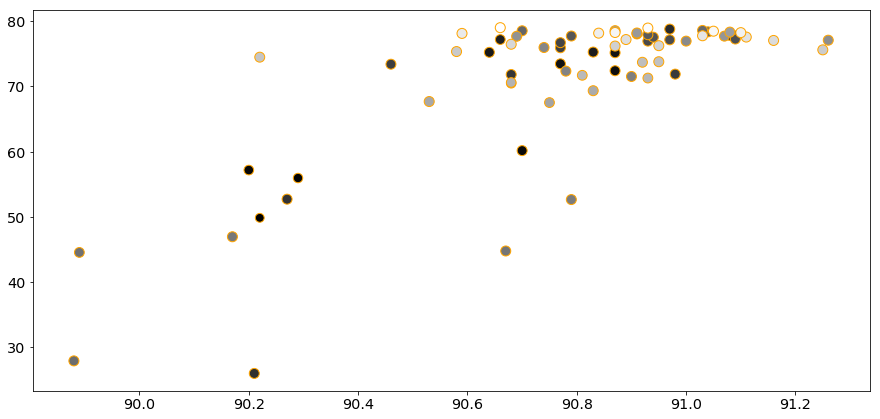

In [11]:
df_resnet20_ft60 = pd.read_csv(os.path.join(fpath, "ft_60epoch_results.csv"))
#df_plain20_ft2 = pd.read_csv("../experiments/plain20-ddpg-private/2019.07.24-174636/ft_2epoch_results.csv")

from scipy.stats.stats import pearsonr

def shorten_dir_name(df):
    df_grouped = df.groupby('dir') 
    df['dir'] = df['dir'].map(lambda x: x[len("experiments/plain20-ddpg-private/"):])
    df['exp'] = df['dir'].map(lambda x: x.split("___")[0][-1])
    
def create_fig(df):
    plt.figure(figsize=(15,7))
    cnt_nets = len(df.index)
    plt.grid(True)
    #plt.legend()
    plt.title("Discovered Networks:\nComparing Search Top1 vs Fine-tuned Top1\n")
    plt.xlabel("Fine-tuned Top1 Accuracy")
    plt.ylabel("Search Top1 Accuracy")

def plot_networks(df, edgecolors, create_figure=True):
    if create_figure:
        create_fig(df)
    size = df.macs / max(df.macs) * 100
    plt.scatter(df.top1, df.search_top1, s=size, c=df.index, edgecolors=edgecolors, cmap='gray')
    print("Best network: %.2f" % max(df.top1))
    print("Pearson: %.3f" % pearsonr(df.top1, df.search_top1)[0])
    df_sorted = df.sort_values(by=['top1'], inplace=False, ascending=False)
    # Five best
    print(df_sorted[:5][['exp', 'search_top1', 'top1', 'name']])#[('name','top1')])

#shorten_dir_name(df_plain20_ft2)
shorten_dir_name(df_resnet20_ft60)
#plot_networks(df_plain20_ft2, edgecolors='green')
plot_networks(df_resnet20_ft60, edgecolors='orange', create_figure=False)
print(len(df_resnet20_ft60.index))


Let's zoom-in on the FT60 networks.<br>
Remember, we ran our AMC experiment 4 times, and we fine-tuned networks discovered in each of these 4 experiments. Now let's separate these networks by color and observe how they cluster.

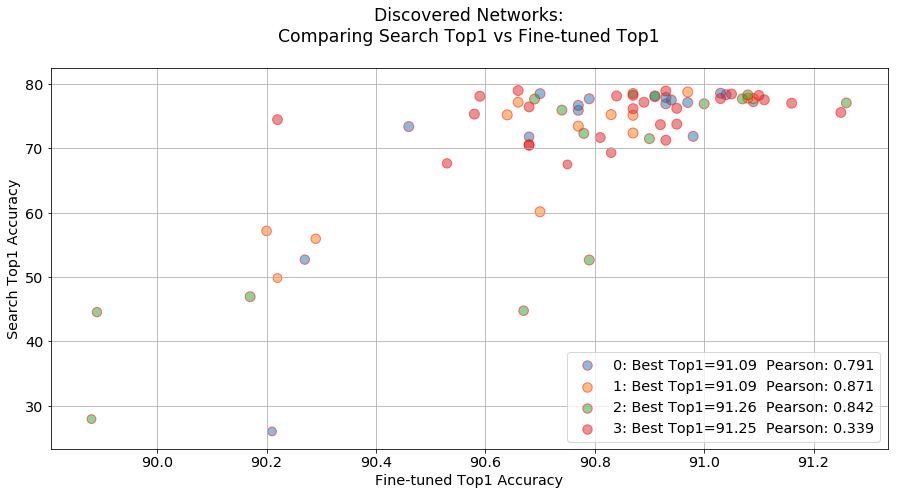

In [12]:
def plot_networks_by_experiment(df, edgecolors, create_figure=True):
    if create_figure:
        create_fig(df)
    
    # Group by experiment directory
    df_grouped = df.groupby('exp') 
    size = df.macs / max(df.macs) * 100
    legend = []
    for exp_dir, df_experiment in df_grouped:
        a = plt.scatter(df_experiment.top1, df_experiment.search_top1, s=size,
                        edgecolors=edgecolors, alpha=0.5)
        p = pearsonr(df_experiment.top1, df_experiment.search_top1)[0]
        legend.append((a, "%s: Best Top1=%.2f  Pearson: %.3f" % (exp_dir, max(df_experiment.top1), p)))
    plots, labels = zip(*legend)
    plt.legend(plots, labels)

plot_networks_by_experiment(df_resnet20_ft60, edgecolors='red')#, create_figure=False)

(0.24326047898877914, 0.159090334287795)


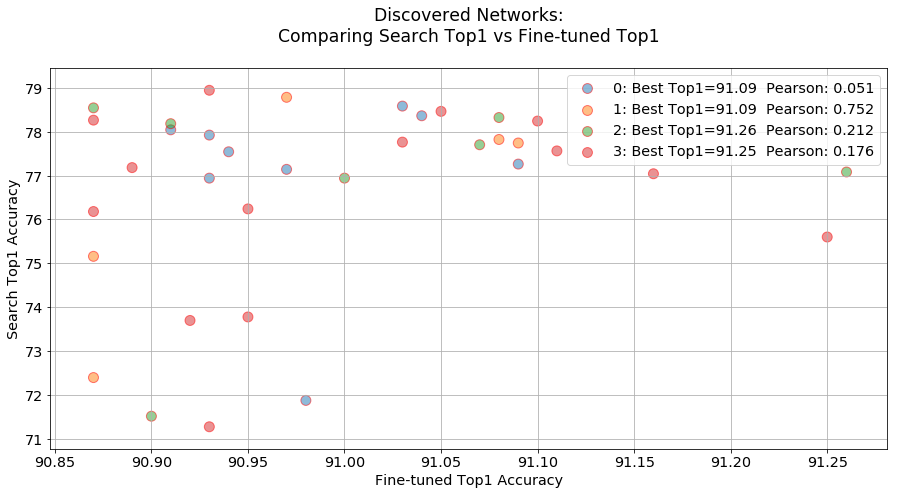

In [14]:
df_sorted = df_resnet20_ft60.sort_values(by=['top1'], ascending=False)
df_sorted = df_sorted[:int(len(df_sorted.index) * 0.5)]  # Top 30% models
plot_networks_by_experiment(df_sorted, edgecolors='red')

from scipy.stats.stats import pearsonr
print(pearsonr(df_sorted.top1, df_sorted.search_top1))

## Clipped PPO - TO DO BASED ON THIS PLAIN20 CODE

time python3 multi-run.py experiments/plain20-ppo-coach compress_classifier.py --arch=plain20_cifar ${CIFAR10_PATH} --resume=checkpoint.plain20_cifar.pth.tar --lr=0.05 --amc --amc-protocol=mac-constrained --amc-action-range 0.05 1.0 --amc-target-density=0.5 -p=50 --etes=0.075 --amc-ft-epochs=0 --amc-prune-pattern=channels --amc-prune-method=fm-reconstruction --amc-agent-algo=ClippedPPO-continuous --amc-cfg=../automated_deep_compression/auto_compression_channels.yaml --evs=0.5 --etrs=0.5 --amc-rllib=coach -j=1

In [15]:
fpath = "../experiments/plain20-ppo-coach/2019.07.28-012356/"
df_list = load_experiment_instances(fpath)
df_len = min([len(df) for df in df_list])

plot_experiment_comparison(df_list)

FileNotFoundError: [Errno 2] No such file or directory: '../experiments/plain20-ppo-coach/2019.07.28-012356/'

time python parallel-finetune.py --scan-dir=experiments/plain20-ppo-coach/2019.07.28-012356 --arch=plain20_cifar --lr=0.1 --vs=0 -p=50 --compress=../automated_deep_compression/fine_tune.yaml ${CIFAR10_PATH} -j=1 --epochs=60 --output-csv=ft_60epoch_results.csv --processes=16

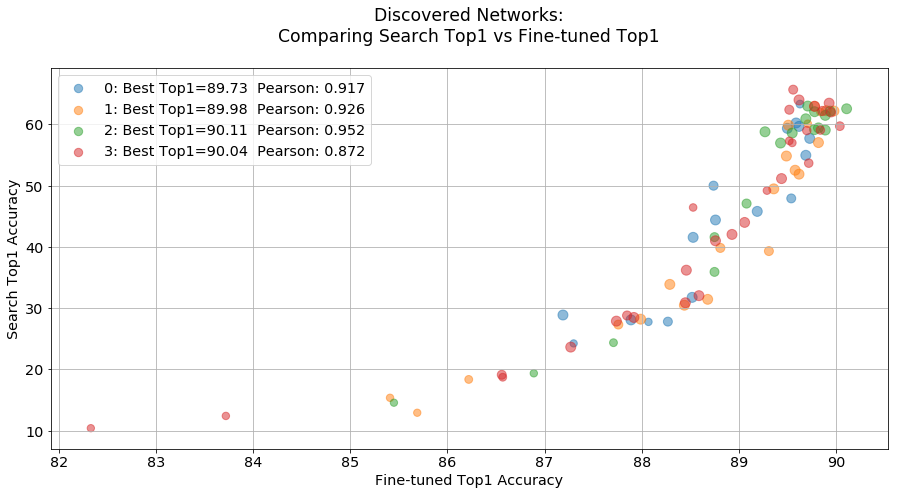

In [45]:
df_plain20_ft60 = pd.read_csv(os.path.join(fpath, "ft_60epoch_results.csv"))
shorten_dir_name(df_plain20_ft60)
plot_networks_by_experiment(df_plain20_ft60, edgecolors=None)

## Using a different reward function

    time python3 multi-run.py experiments/plain20-ddpg-private-punish compress_classifier.py --arch=plain20_cifar ${CIFAR10_PATH} --resume=checkpoint.plain20_cifar.pth.tar --lr=0.05 --amc --amc-protocol=punish-agent --amc-action-range 0.05 1.0 --amc-target-density=0.5 -p=50 --etes=0.075 --amc-ft-epochs=0 --amc-prune-pattern=channels --amc-prune-method=fm-reconstruction --amc-agent-algo=DDPG --amc-cfg=../automated_deep_compression/auto_compression_channels.yaml --evs=0.5 --etrs=0.5 --amc-rllib=private -j=1

In [50]:
fpath = "../experiments/plain20-ddpg-private-punish/2019.07.29-171102/"
df_list = load_experiment_instances(fpath)
df_len = min([len(df) for df in df_list])

plot_experiment_comparison(df_list)

interactive(children=(IntSlider(value=10, description='window_size', max=50, step=5), IntSlider(value=0, description='zoom', max=800), Output()), _dom_classes=('widget-interact',))

time python parallel-finetune.py --scan-dir=../automated_deep_compression/experiments/plain20-ddpg-private-punish/2019.07.29-171102 --arch=plain20_cifar --lr=0.1 --vs=0 -p=50 --compress=../automated_deep_compression/plain20_fine_tune.yaml ${CIFAR10_PATH} -j=1 --epochs=60 --output-csv=ft_60epoch_results.csv --processes=16

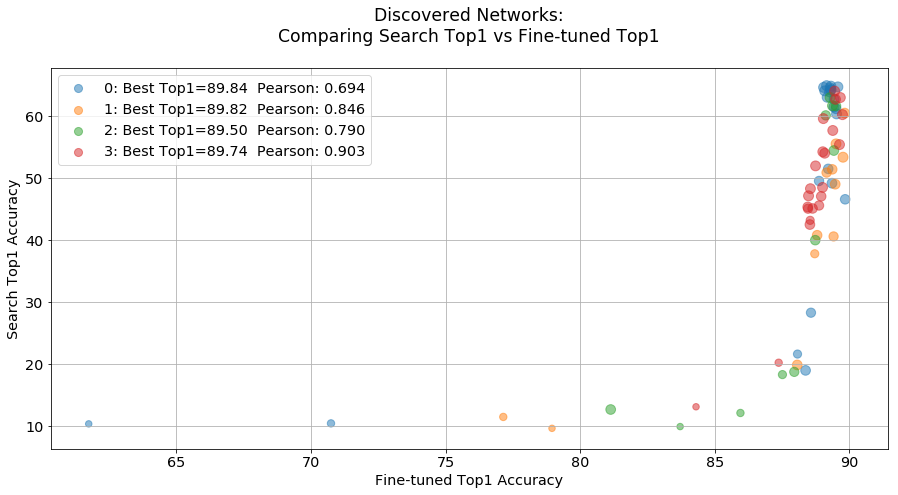

In [59]:
df_plain20_ft60 = pd.read_csv(os.path.join(fpath, "ft_60epoch_results.csv"))
shorten_dir_name(df_plain20_ft60)
#df_plain20_ft60 = df_plain20_ft60[df_plain20_ft60[df_plain20_ft60.macs] >= 50.5] 
plot_networks_by_experiment(df_plain20_ft60, edgecolors=None)